In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Baffin = pd.read_excel(filepath, sheet_name='Baffin-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Baffin)
fp.date_time(Baffin)

,Extent,Date
0,1090625.815,1979-01-01
1,1157634.866,1979-02-01
2,1299583.477,1979-03-01
3,1137194.680,1979-04-01
4,983083.453,1979-05-01
...,...,...
533,781460.891,2023-06-01
534,331845.048,2023-07-01
535,99334.625,2023-08-01
536,49359.723,2023-09-01


In [5]:
scaler = MinMaxScaler()
Baffin['Extent'] = scaler.fit_transform(Baffin['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 8
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Baffin['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((519, 12, 1), (519,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Baffin_model_LT8/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 35s 468ms/step - loss: 0.1893 - root_mean_squared_error: 0.4350 - val_loss: 0.0934 - val_root_mean_squared_error: 0.3056
Epoch 2/50
53/53 [==============================] - 24s 467ms/step - loss: 0.0746 - root_mean_squared_error: 0.2730 - val_loss: 0.0622 - val_root_mean_squared_error: 0.2493
Epoch 3/50
53/53 [==============================] - 23s 449ms/step - loss: 0.0582 - root_mean_squared_error: 0.2412 - val_loss: 0.0503 - val_root_mean_squared_error: 0.2243
Epoch 4/50
53/53 [==============================] - 24s 464ms/step - loss: 0.0457 - root_mean_squared_error: 0.2138 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1850
Epoch 5/50
53/53 [==============================] - 24s 458ms/step - loss: 0.0309 - root_mean_squared_error: 0.1758 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1335
Epoch 6/50
53/53 [==============================] - 24s 455ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0093 

Epoch 37/50
53/53 [==============================] - 3s 57ms/step - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 38/50
53/53 [==============================] - 3s 54ms/step - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0560
Epoch 39/50
53/53 [==============================] - 3s 54ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0552
Epoch 40/50
53/53 [==============================] - 3s 52ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 41/50
53/53 [==============================] - 3s 53ms/step - loss: 0.0052 - root_mean_squared_error: 0.0721 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 42/50
53/53 [==============================] - 3s 52ms/step - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0034 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

7.063175284862519 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

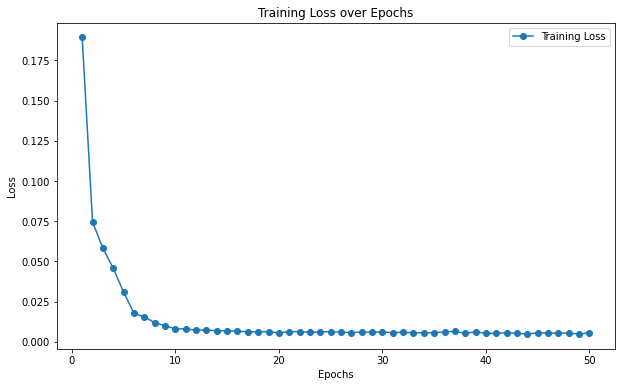

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

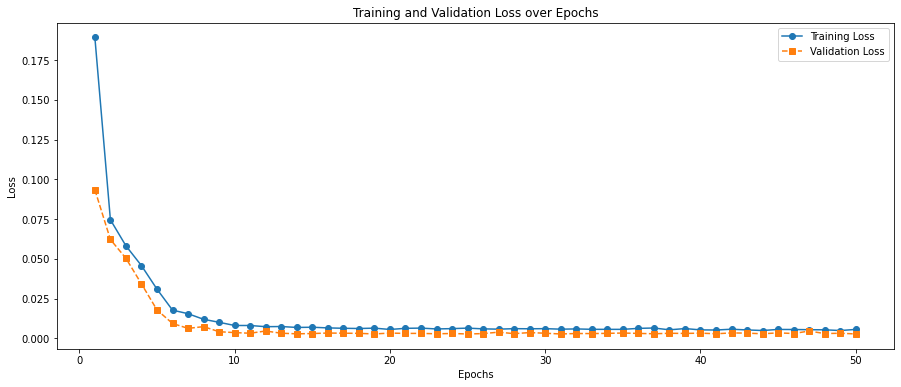

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Baffin_model_LT8/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 33ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.05274958489753161
MAE : 0.03832569520329854


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,8.142671e+05,678576.504
1,1.058605e+06,974461.347
2,1.184008e+06,1181121.087
3,1.189884e+06,1236299.254
4,1.075777e+06,1036981.003
5,8.730631e+05,847489.150
6,6.082396e+05,619129.338
7,3.347031e+05,195688.491
8,7.226255e+04,36670.811
9,-3.046680e+04,31777.310


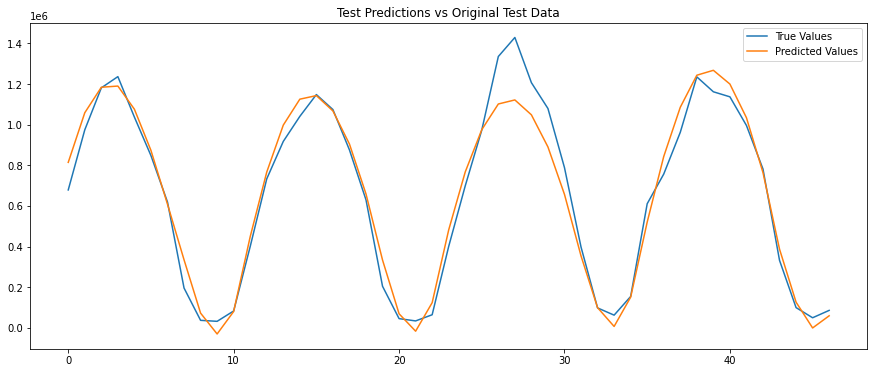

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 32ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

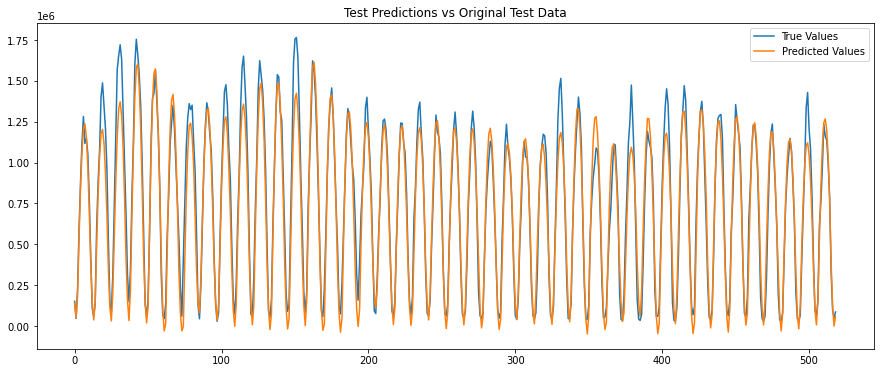

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()